In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.decomposition import PCA
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import joblib
!pip install seaborn
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
!pip install lightgbm
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Ensure the directories for saving data exist
def create_directories():
    if not os.path.exists('data/'):
        os.makedirs('data/')
        print("Created directory: data/")
    if not os.path.exists('models/'):
        os.makedirs('models/')
        print("Created directory: models/")

create_directories()  # Create the necessary directories


In [2]:
import joblib
def save_model_instance(instance, filename):
    print(f"Saving model instance: {filename}...")
    if filename.endswith('.pkl'):
        joblib.dump(instance, f'/home/angadjeet22071/ml-project/ML-Project-Network_Intrusion_Detection/models/{filename}')
    else:
        np.save(f'/home/angadjeet22071/ml-project/ML-Project-Network_Intrusion_Detection/models/{filename}.npy', instance)
def load_model_instance(filename):
    print(f"Loading model instance: {filename}...")
    if filename.endswith('.pkl'):
        return joblib.load(f'/home/angadjeet22071/ml-project/ML-Project-Network_Intrusion_Detection/models/{filename}')
    else:
        return np.load(f'/home/angadjeet22071/ml-project/ML-Project-Network_Intrusion_Detection/models/{filename}.npy', allow_pickle=True).item()

In [3]:
def load_and_split_data(df, target_column='outcome', test_size=0.2, random_state=42):
    print("Loading and splitting the dataset...")
    X = df.drop(target_column, axis=1)  # Features
    Y = df[target_column]  # Target
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state, stratify=Y)

    # Save the split data
    X_train.to_csv('data/X_train.csv', index=False)
    X_test.to_csv('data/X_test.csv', index=False)
    Y_train.to_csv('data/Y_train.csv', index=False)
    Y_test.to_csv('data/Y_test.csv', index=False)

    print("Data split into training and testing sets.")
    return X_train, X_test, Y_train, Y_test

def categorize_attack_type(label):
    if label in dos_attacks:
        return 'DOS'
    elif label in r2l_attacks:
        return 'R2L'
    elif label in u2r_attacks:
        return 'U2R'
    elif label in probe_attacks:
        return 'probing'
    else:
        return 'normal'
    
df = pd.read_csv('data_with_column_names.csv')

dos_attacks = ['smurf.', 'neptune.', 'back.', 'teardrop.', 'pod.', 'land.']
r2l_attacks = ['warezclient.', 'guess_passwd.', 'imap.', 'warezmaster.', 'ftp_write.', 'phf.', 'spy.', 'multihop.']
u2r_attacks = ['buffer_overflow.', 'loadmodule.', 'rootkit.', 'perl.']
probe_attacks = ['satan.', 'ipsweep.', 'portsweep.', 'nmap.']
df['outcome'] = df['outcome'].apply(categorize_attack_type)
target_column = 'outcome'

In [4]:
# One-hot encoding categorical features
def one_hot_encode(X_train, X_test, categorical_columns):
    print("One-hot encoding categorical features...")
    encoders = {}
    X_train_encoded_list = []
    X_test_encoded_list = []
    feature_names = []
    for col in categorical_columns:
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        X_train_col_encoded = encoder.fit_transform(X_train[[col]])
        X_train_encoded_list.append(X_train_col_encoded)
        X_test_col_encoded = encoder.transform(X_test[[col]])
        X_test_encoded_list.append(X_test_col_encoded)
        encoders[col] = encoder
        feature_names.extend(encoder.get_feature_names_out([col]))
        save_model_instance(encoder, f'encoder_{col}')
    
    X_train_encoded = np.concatenate(X_train_encoded_list, axis=1)
    X_test_encoded = np.concatenate(X_test_encoded_list, axis=1)

    X_train_remaining = X_train.drop(columns=categorical_columns)
    X_test_remaining = X_test.drop(columns=categorical_columns)
    
    X_train_final = np.concatenate([X_train_remaining.values, X_train_encoded], axis=1)
    X_test_final = np.concatenate([X_test_remaining.values, X_test_encoded], axis=1)
    
    if not os.path.exists('data'):
        os.makedirs('data')

    np.save('data/X_train_encoded.npy', X_train_final)
    np.save('data/X_test_encoded.npy', X_test_final)

    print("Categorical features encoded and original columns removed.")
    return X_train_final, X_test_final, encoders

categorical_columns = ['protocol_type', 'service', 'flag']

In [5]:
# Apply Robust Scaling
def robust_scale(X_train, X_test):
    print("Applying robust scaling...")
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    np.save('data/X_train_scaled.npy', X_train_scaled)
    np.save('data/X_test_scaled.npy', X_test_scaled)
    print("Data scaled using RobustScaler.")
    save_model_instance(scaler, 'scaler')
    return X_train_scaled, X_test_scaled, scaler

In [6]:
# Apply SMOTEENN resampling
def apply_smoteenn(X_train, Y_train):
    print("Applying SMOTEENN for resampling...")
    smote_enn = SMOTEENN(sampling_strategy='auto', random_state=42)
    X_train_resampled, Y_train_resampled = smote_enn.fit_resample(X_train, Y_train)
    np.save('data/X_train_resampled.npy', X_train_resampled)
    np.save('data/Y_train_resampled.npy', Y_train_resampled)
    print("Data resampled using SMOTEENN.")
    print(f"Resampled Y distribution: {Counter(Y_train_resampled)}")
    resampled_data = pd.DataFrame(X_train_resampled)
    resampled_data['outcome'] = Y_train_resampled
    resampled_data.to_csv('resampled_data.csv', index=False)
    return X_train_resampled, Y_train_resampled

In [7]:
from sklearn.feature_selection import VarianceThreshold, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from boruta import BorutaPy
from scipy.stats import ranksums
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# def feature_selection(X_train, Y_train, variance_threshold=0.01, k_best=20, correlation_threshold=0.1):\n",
#     "    print(\"Starting feature selection...\")\n",
#     "\n",
#     "    # Variance Threshold\n",
#     "    vt = VarianceThreshold(threshold=variance_threshold)\n",
#     "    X_train_var = vt.fit_transform(X_train)\n",
#     "\n",
#     "    # Calculate correlation matrix\n",
#     "    correlation_matrix = pd.DataFrame(X_train_var).corrwith(pd.Series(Y_train))\n",
#     "    low_corr_features = correlation_matrix[correlation_matrix.abs() < correlation_threshold].index\n",
#     "    # add these features in a npy file that conain all deleted features highly and low correlated\n",
#     "    np.save('data/low_corr_features.npy', low_corr_features)\n",
#     "\n",
#     "    X_train_var = np.delete(X_train_var, low_corr_features, axis=1)\n",
#     "\n",
#     "    print(f\"Removed low correlation features: {low_corr_features.tolist()}\")\n",
#     "\n",
#     "    # Keep one feature from highly correlated features\n",
#     "    corr_matrix = pd.DataFrame(X_train_var).corr().abs()\n",
#     "    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))\n",
#     "    to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]\n",
#     "    np.save('data/high_corr_features.npy', to_drop)\n",
#     "\n",
#     "    # Retain only one feature from the highly correlated ones\n",
#     "    X_train_var = np.delete(X_train_var, to_drop, axis=1)\n",
#     "    print(f\"Removed highly correlated features: {to_drop}\")\n",
#     "\n",
#     "    # Mutual Information to select K best features\n",
#     "    selector = SelectKBest(mutual_info_classif, k=k_best)\n",
#     "    X_train_selected = selector.fit_transform(X_train_var, Y_train)\n",
#     "\n",
#     "    # Save the selected features\n",
#     "    np.save('data/X_train_selected.npy', X_train_selected)\n",
#     "\n",
#     "    print(f\"Selected {k_best} best features using mutual information.\")\n",
#     "    save_model_instance(selector, 'selector')\n",
#     "    return X_train_selected, selector\n",
#     "\n",
#     "# X_train_selected, selector = feature_selection(X_train_resampled, Y_train_resampled)\n"
#     "    return X_train_selected, selector"

def feature_selector(X_train, Y_train, params_grid):
    results = []  # To store results for plotting
    
    for params in params_grid:
        print(f"Running feature selection with parameters: {params}")
        
        # Extract parameters
        variance_threshold = params['variance_threshold']
        correlation_threshold = params['correlation_threshold']
        p_value_threshold = params['p_value_threshold']
        top_k_chi2 = params['top_k_chi2']
        max_depth_rf = params['max_depth_rf']
        
        # Step 1: Variance Threshold
        vt = VarianceThreshold(threshold=variance_threshold)
        X_train_var = vt.fit_transform(X_train)
        print(f"Features after Variance Threshold: {X_train_var.shape[1]}")
        
        # Step 2: Low Correlation Features Removal
        correlation_matrix = pd.DataFrame(X_train_var).corrwith(pd.Series(Y_train))
        low_corr_features = correlation_matrix[correlation_matrix.abs() < correlation_threshold].index
        X_train_var = np.delete(X_train_var, low_corr_features, axis=1)
        print(f"Removed low correlation features: {len(low_corr_features)}")

        # Step 3: High Correlation Features Removal
        corr_matrix = pd.DataFrame(X_train_var).corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
        X_train_var = np.delete(X_train_var, to_drop, axis=1)
        print(f"Removed highly correlated features: {len(to_drop)}")

        # Step 4: Rank Sum Test-based Feature Selection
        significant_features = []
        for i in range(X_train_var.shape[1]):
            group1 = X_train_var[Y_train == 0, i]  # Class 0
            group2 = X_train_var[Y_train == 1, i]  # Class 1
            _, p_value = ranksums(group1, group2)  # Perform Rank Sum Test
            if p_value < p_value_threshold:
                significant_features.append(i)
        X_train_var = X_train_var[:, significant_features]
        print(f"Features selected by Rank Sum Test: {len(significant_features)}")

        # Step 5: Chi-Square Test Feature Selection
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train_var)
        chi2_scores, _ = chi2(X_train_scaled, Y_train)
        chi2_selected_indices = np.argsort(chi2_scores)[-top_k_chi2:]
        X_train_var = X_train_var[:, chi2_selected_indices]
        print(f"Features selected by Chi-Square Test: {len(chi2_selected_indices)}")
        
        # Step 6: Boruta Feature Selection
        forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=max_depth_rf, random_state=42)
        boruta_selector = BorutaPy(estimator=forest, n_estimators='auto', random_state=42)
        boruta_selector.fit(X_train_var, Y_train)
        X_train_selected = boruta_selector.transform(X_train_var)
        print(f"Features selected by Boruta: {X_train_selected.shape[1]}")
        
        # Save results for plotting
        results.append({
            'parameters': params,
            'num_features_selected': X_train_selected.shape[1]
        })

    # Plot results: Number of features selected vs. hyperparameters
    selected_features = [res['num_features_selected'] for res in results]
    param_combinations = [str(res['parameters']) for res in results]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(selected_features)), selected_features)
    plt.xlabel('Parameter Combination Index')
    plt.ylabel('Number of Features Selected')
    plt.title('Number of Features Selected vs. Hyperparameters')
    plt.xticks(range(len(selected_features)), param_combinations, rotation=90, fontsize=8)
    plt.tight_layout()
    plt.show()
    
    return X_train_selected
    
    
    
    # Define hyperparameter grid for tuning
param_grid = [
    {
        'variance_threshold': vt,
        'correlation_threshold': ct,
        'p_value_threshold': pval,
        'top_k_chi2': k,
        'max_depth_rf': md_rf
    }
    for vt in [0.01, 0.05, 0.1]               # Variance thresholds
    for ct in [0.1, 0.2]                      # Correlation thresholds
    for pval in [0.01, 0.05]                  # Rank Sum p-value thresholds
    for k in [10, 20, 50]                     # Top K features for Chi2
    for md_rf in [3, 5, 7]                    # Random Forest max depth
]


In [8]:
# #CODE FOR OULTLIER REMOVAL(NOT DEPLOYED)

# import numpy as np
# import pandas as pd
# from sklearn.ensemble import IsolationForest
# from sklearn.neighbors import LocalOutlierFactor
# from sklearn.covariance import EllipticEnvelope
# from sklearn.preprocessing import LabelEncoder, RobustScaler
# from sklearn.metrics import classification_report, accuracy_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split

# # Example data: Replace this with your actual data
# # df = pd.read_csv('your_data.csv')
# # Assuming df is your dataframe with features and 'outcome' column as the target
# X = df.drop('outcome', axis=1)
# Y = df['outcome']

# # Split into train and test sets
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# # Apply one-hot encoding to categorical features
# from sklearn.preprocessing import OneHotEncoder

# encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# X_train_1 = encoder.fit_transform(X_train[['protocol_type']])
# X_test_1 = encoder.transform(X_test[['protocol_type']])

# X_train_2 = encoder.fit_transform(X_train[['service']])
# X_test_2 = encoder.transform(X_test[['service']])

# X_train_3 = encoder.fit_transform(X_train[['flag']])
# X_test_3 = encoder.transform(X_test[['flag']])

# # Concatenate encoded and numeric features
# X_train_combined = np.concatenate([X_train_1, X_train_2, X_train_3, X_train.drop(['protocol_type', 'service', 'flag'], axis=1).values], axis=1)
# X_test_combined = np.concatenate([X_test_1, X_test_2, X_test_3, X_test.drop(['protocol_type', 'service', 'flag'], axis=1).values], axis=1)

# # Initialize RobustScaler and apply it to the training set
# scaler = RobustScaler()
# X_train_scaled = scaler.fit_transform(X_train_combined)
# X_test_scaled = scaler.transform(X_test_combined)

# # Encode the target variable
# label_encoder = LabelEncoder()
# Y_train_encoded = label_encoder.fit_transform(Y_train)
# Y_test_encoded = label_encoder.transform(Y_test)

# # --------------------------------
# # Step 1: Detect Outliers (Isolation Forest, LOF, Elliptic Envelope)
# # --------------------------------

# # Isolation Forest
# iso_forest = IsolationForest(contamination=0.1, random_state=42)
# iso_forest.fit(X_train_scaled)
# train_iso_pred = iso_forest.predict(X_train_scaled)
# test_iso_pred = iso_forest.predict(X_test_scaled)

# # Local Outlier Factor (LOF)
# lof = LocalOutlierFactor(contamination=0.1)
# train_lof_pred = lof.fit_predict(X_train_scaled)

# # Elliptic Envelope
# elliptic = EllipticEnvelope(contamination=0.1)
# elliptic.fit(X_train_scaled)
# train_elliptic_pred = elliptic.predict(X_train_scaled)
# test_elliptic_pred = elliptic.predict(X_test_scaled)

# # Convert outliers (-1) to 1, inliers (1) to 0 for binary classification
# train_iso_pred[train_iso_pred == 1] = 0
# train_iso_pred[train_iso_pred == -1] = 1
# test_iso_pred[test_iso_pred == 1] = 0
# test_iso_pred[test_iso_pred == -1] = 1

# train_lof_pred[train_lof_pred == 1] = 0
# train_lof_pred[train_lof_pred == -1] = 1

# train_elliptic_pred[train_elliptic_pred == 1] = 0
# train_elliptic_pred[train_elliptic_pred == -1] = 1
# test_elliptic_pred[test_elliptic_pred == 1] = 0
# test_elliptic_pred[test_elliptic_pred == -1] = 1

# # --------------------------------
# # Step 2: Remove Outliers Based on Isolation Forest
# # --------------------------------

# # Filter out outliers (where prediction is 0)
# X_train_cleaned = X_train_scaled[train_iso_pred == 0]
# Y_train_cleaned = Y_train_encoded[train_iso_pred == 0]

# X_test_cleaned = X_test_scaled[test_iso_pred == 0]
# Y_test_cleaned = Y_test_encoded[test_iso_pred == 0]

# # --------------------------------
# # Step 3: Train Classifier After Removing Outliers
# # --------------------------------

# # Example classifier: Logistic Regression
# clf = LogisticRegression(random_state=42)
# clf.fit(X_train_cleaned, Y_train_cleaned)

# # Make predictions on cleaned test set
# predictions = clf.predict(X_test_cleaned)

# # Evaluate the model
# print('Classification Report:')
# print(classification_report(Y_test_cleaned, predictions, zero_division=0))

# accuracy = accuracy_score(Y_test_cleaned, predictions)
# print(f"Model Accuracy: {accuracy:.4f}")

# # --------------------------------
# # Optional: Try LOF and Elliptic Envelope to Clean Data
# # --------------------------------
# # For LOF or Elliptic Envelope, follow a similar approach:
# # - Use the predictions from the models (train_lof_pred or train_elliptic_pred)
# # - Filter out the outliers and retrain the classifier


In [9]:
resampled_data = pd.read_csv('resampled_data.csv')
X_train_resampled = resampled_data.drop('outcome', axis=1)
Y_train_resampled = resampled_data['outcome']
# X_train_resampled2 = X_train_resampled[:10]#this was used for local testing
# Y_train_resampled2 = Y_train_resampled[:10]
# resampled data csv and other pretrained models could be found on https://drive.google.com/drive/folders/1B0Z_7_RDMCRIXA0Hf9T5sqygIYuh8NBi?usp=sharing

In [10]:
create_directories()
X_train, X_test, Y_train, Y_test = load_and_split_data(df, target_column)
X_train_encoded, X_test_encoded, encoders = one_hot_encode(X_train, X_test, categorical_columns)
X_train_scaled, X_test_scaled, scaler = robust_scale(X_train_encoded, X_test_encoded)
test_data = pd.DataFrame(X_test_scaled)
test_data['outcome'] = Y_test
test_data.to_csv('test_data.csv', index=False)

Loading and splitting the dataset...
Data split into training and testing sets.
One-hot encoding categorical features...
Saving model instance: encoder_protocol_type...
Saving model instance: encoder_service...
Saving model instance: encoder_flag...
Categorical features encoded and original columns removed.
Applying robust scaling...
Data scaled using RobustScaler.
Saving model instance: scaler...


In [11]:
# Complete pipeline function to execute all steps
def complete_preprocessing_pipeline(df, target_column, categorical_columns, X_train_resampled=None, Y_train_resampled=None):
    if not os.path.exists('/home/angadjeet22071/ml-project/ML-Project-Network_Intrusion_Detection/resampled_data.csv'):
        print("Resampled data not found. Applying preprocessing steps...")
        create_directories()
        X_train, X_test, Y_train, Y_test = load_and_split_data(df, target_column)
        X_train_encoded, X_test_encoded, encoders = one_hot_encode(X_train, X_test, categorical_columns)
        X_train_scaled, X_test_scaled, scaler = robust_scale(X_train_encoded, X_test_encoded)
        test_data = pd.DataFrame(X_test_scaled)
        test_data['outcome'] = Y_test
        test_data.to_csv('test_data.csv', index=False)
        X_train_resampled, Y_train_resampled = apply_smoteenn(X_train_scaled, Y_train)
    else:
        print("Resampled data found. Skipping preprocessing steps...")
        resampled_data = pd.read_csv('/home/angadjeet22071/ml-project/ML-Project-Network_Intrusion_Detection/resampled_data.csv')
        X_train_resampled = resampled_data.drop('outcome', axis=1)
        Y_train_resampled = resampled_data['outcome']
        label_encoder = LabelEncoder()
        Y_train_resampled = label_encoder.fit_transform(Y_train_resampled)
        save_model_instance(label_encoder, 'label_encoder')
    X_train_selected = feature_selector(X_train_resampled, Y_train_resampled, param_grid)
    selected_data = pd.DataFrame(X_train_selected)
    selected_data['outcome'] = Y_train_resampled
    selected_data.to_csv('selected_data.csv', index=False)

In [ ]:
complete_preprocessing_pipeline(df, target_column='outcome', categorical_columns=categorical_columns, X_train_resampled=X_train_resampled, Y_train_resampled=Y_train_resampled)

In [12]:
def load_model_instance(filename):
    print(f"Loading model instance: {filename}...")
    return np.load(f'models/{filename}.npy', allow_pickle=True).item()

selector = load_model_instance('selector')

Loading model instance: selector...


/home/angadjeet22071/miniconda3/envs/ml-project/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SelectKBest from version 1.4.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [13]:
Train_data = pd.read_csv('/home/angadjeet22071/ml-project/ML-Project-Network_Intrusion_Detection/selected_data.csv')
Test_data = pd.read_csv('/home/angadjeet22071/ml-project/ML-Project-Network_Intrusion_Detection/test_data.csv')

X_train_selected = Train_data.drop('outcome', axis=1)
Y_train_resampled = Train_data['outcome']

In [14]:
selected_features = selector.get_support(indices=True)
selected_features = [i for i in selected_features if i < len(Train_data.columns)]
selected_feature_names = Train_data.columns[selected_features]
print(selected_feature_names)

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', 'outcome'], dtype='object')


In [15]:
#this addded to reinstantiate Y_test
X_train_temp, X_test_temp, Y_train_temp, Y_test = load_and_split_data(df, target_column)

Loading and splitting the dataset...
Data split into training and testing sets.


In [16]:
X_test = np.load('data/X_test_scaled.npy')
selected_data = pd.read_csv('/home/angadjeet22071/ml-project/ML-Project-Network_Intrusion_Detection/selected_data.csv')
selected_columns = selected_data.columns.tolist()
selected_columns.remove('outcome')
selected_indices = [selected_data.columns.get_loc(col) for col in selected_columns]
X_test_selected = X_test[:, selected_indices]
X_test_selected = pd.DataFrame(X_test_selected, columns=selected_columns)
X_test_selected['outcome'] = Y_test

print(type(X_train_selected))
print(type(X_test_selected))
if isinstance(X_train_selected, pd.DataFrame) and isinstance(X_test_selected, pd.DataFrame):
    print("Converting selected data to numpy arrays...")
    X_test_selected = X_test_selected[X_train_selected.columns]
label_encoder = load_model_instance('label_encoder')
Y_test_encoded = label_encoder.fit_transform(Y_test)
Y_test_encoded = pd.Series(Y_test_encoded)
print(Y_test_encoded.value_counts())
print(Y_train_resampled.value_counts())

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
Converting selected data to numpy arrays...
Loading model instance: label_encoder...
0    78292
3    19456
4      822
1      225
2       10
Name: count, dtype: int64
outcome
4    313002
2    312997
0    312966
1    312253
3    311917
Name: count, dtype: int64


In [17]:
# apply vanila perceptron model for multiclass classification
clf = Perceptron()
clf.fit(X_train_selected, Y_train_resampled)
X_test_selected = X_test_selected[:len(Y_test)]

label_encoder = load_model_instance('label_encoder')
Y_test_encoded = label_encoder.fit_transform(Y_test)
Y_test_encoded = pd.Series(Y_test_encoded)
predictions = clf.predict(X_test_selected)

print(Y_test.value_counts())
print('Classification Report:')
print(classification_report(Y_test_encoded, predictions, zero_division=0))

accuracy = accuracy_score(Y_test_encoded, predictions)
print(f"Model Accuracy: {accuracy:.4f}")

Loading model instance: label_encoder...
outcome
DOS        78292
normal     19456
probing      822
R2L          225
U2R           10
Name: count, dtype: int64
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93     78292
           1       0.00      0.00      0.00       225
           2       0.00      0.00      0.00        10
           3       0.97      0.05      0.10     19456
           4       0.02      0.79      0.05       822

    accuracy                           0.72     98805
   macro avg       0.39      0.34      0.21     98805
weighted avg       0.96      0.72      0.76     98805

Model Accuracy: 0.7196


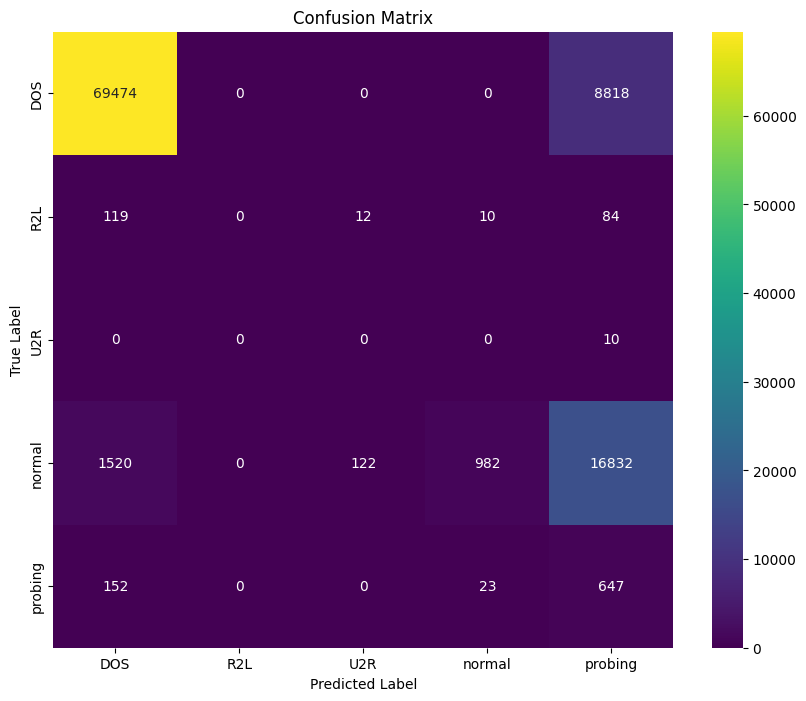

In [18]:
#plot confusion matrix for perceptron model
# label_encoder = load_model_instance('label_encoder')
# Y_test_encoded = label_encoder.fit_transform(Y_test)
# Y_test_encoded = pd.Series(Y_test_encoded)
#LOAD perceptron model from perceptronmodel.pkl
# clf = joblib.load('perceptronmodel.pkl')
predictions = clf.predict(X_test_selected)
cm = confusion_matrix(Y_test_encoded, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
#save plot
plt.savefig('confusion_matrix_perceptron.png')

In [19]:
joblib.dump(clf, 'perceptronmodel.pkl')
print("Model saved as perceptronmodel.pkl.")

Model saved as perceptronmodel.pkl.


ROC-AUC Score (Macro Average): 0.6237146975177147
ROC-AUC Score (Micro Average): 0.7420507195493511


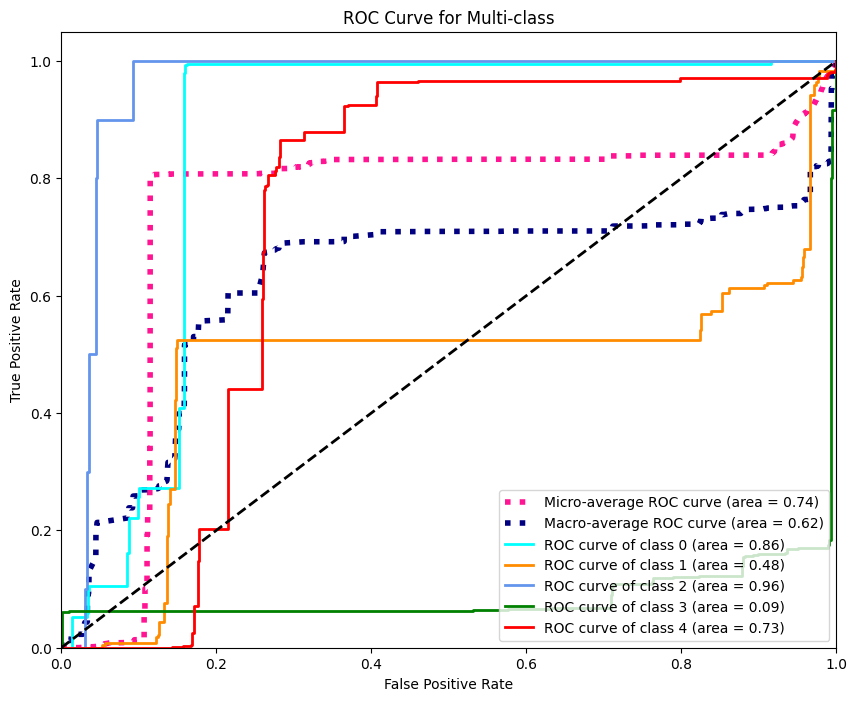

y_test_binarized shape: (98805, 5)
y_score shape: (98805, 5)


In [20]:
y_test_binarized = label_binarize(Y_test_encoded, classes=np.unique(Y_test_encoded))
y_score = clf.decision_function(X_test_selected)
roc_auc_macro = roc_auc_score(y_test_binarized, y_score, average='macro', multi_class='ovr')
roc_auc_micro = roc_auc_score(y_test_binarized, y_score, average='micro', multi_class='ovr')
print("ROC-AUC Score (Macro Average):", roc_auc_macro)
print("ROC-AUC Score (Micro Average):", roc_auc_micro)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC curve (area = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class')
plt.legend(loc="lower right")
plt.show()
print("y_test_binarized shape:", y_test_binarized.shape)
print("y_score shape:", y_score.shape)


In [21]:
clf = DecisionTreeClassifier()
clf.fit(X_train_selected, Y_train_resampled)
predictions = clf.predict(X_test_selected)
print('Classification Report:')
print(classification_report(Y_test_encoded, predictions, zero_division=0))
accuracy = accuracy_score(Y_test_encoded, predictions)
print(f"Model Accuracy: {accuracy:.4f}")
joblib.dump(clf, 'decisiontreemodel.pkl')
print("Model saved as decisiontreemodel.pkl.")

Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     78292
           1       0.00      0.00      0.00       225
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00     19456
           4       0.00      0.00      0.00       822

    accuracy                           0.79     98805
   macro avg       0.16      0.20      0.18     98805
weighted avg       0.63      0.79      0.70     98805

Model Accuracy: 0.7923
Model saved as decisiontreemodel.pkl.


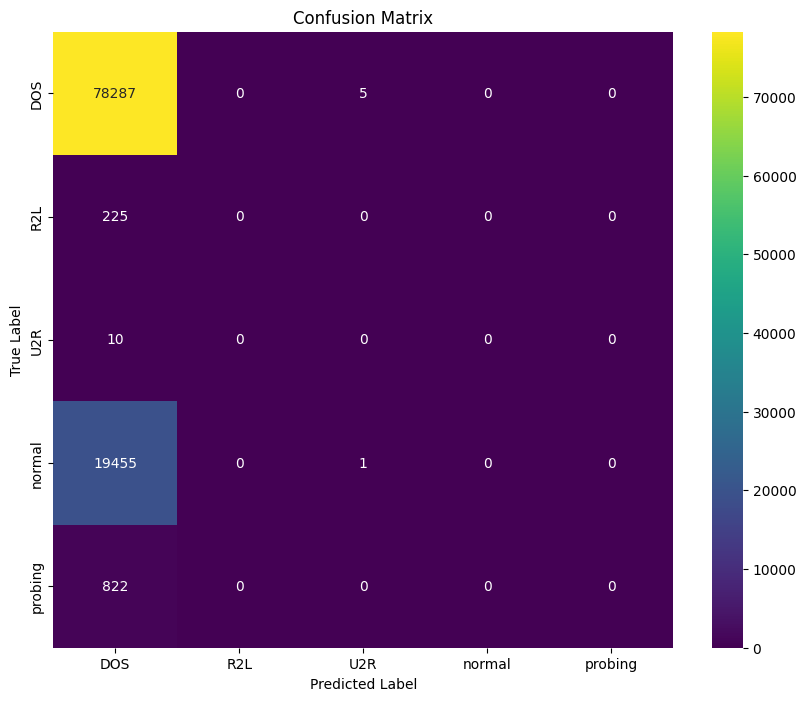

In [22]:
cm = confusion_matrix(Y_test_encoded, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

ROC-AUC Score (Macro Average): 0.4999924154269616
ROC-AUC Score (Micro Average): 0.8702115277566925


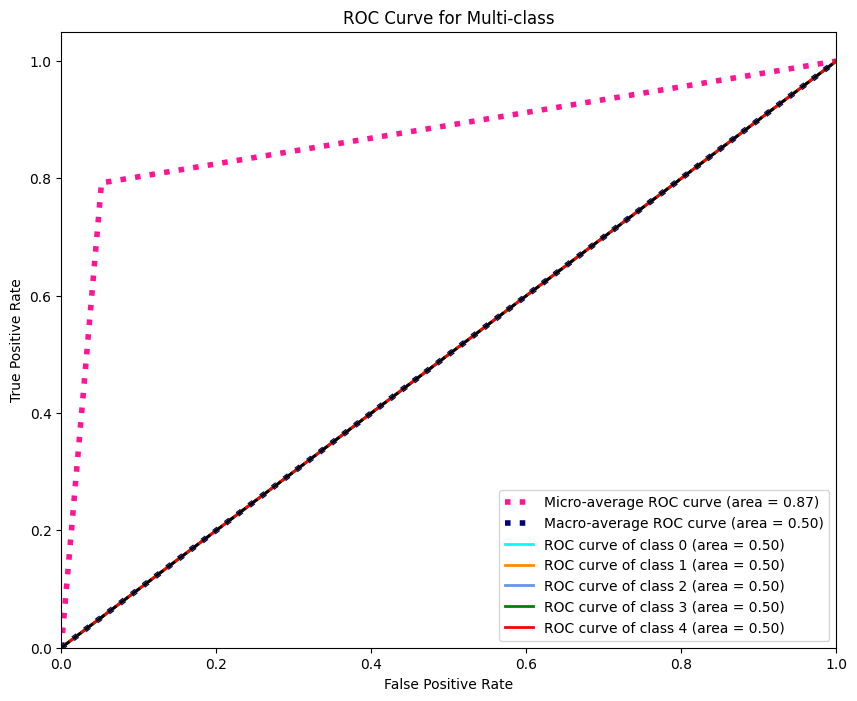

y_test_binarized shape: (98805, 5)
y_score shape: (98805, 5)


In [23]:
y_test_binarized = label_binarize(Y_test_encoded, classes=np.unique(Y_test_encoded))
y_score = clf.predict_proba(X_test_selected)
roc_auc_macro = roc_auc_score(y_test_binarized, y_score, average='macro', multi_class='ovr')
roc_auc_micro = roc_auc_score(y_test_binarized, y_score, average='micro', multi_class='ovr')
print("ROC-AUC Score (Macro Average):", roc_auc_macro)
print("ROC-AUC Score (Micro Average):", roc_auc_micro)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC curve (area = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class')
plt.legend(loc="lower right")
plt.show()

print("y_test_binarized shape:", y_test_binarized.shape)
print("y_score shape:", y_score.shape)


In [24]:
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=300
)
clf.fit(X_train_selected, Y_train_resampled)
predictions = clf.predict(X_test_selected)
print('Classification Report:')
print(classification_report(Y_test_encoded, predictions, zero_division=0))
accuracy = accuracy_score(Y_test_encoded, predictions)
print(f"Model Accuracy: {accuracy:.4f}")
joblib.dump(clf, 'softmaxregressionmodel.pkl')
print("Model saved as softmaxregressionmodel.pkl.")

/home/angadjeet22071/miniconda3/envs/ml-project/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     78292
           1       0.00      0.00      0.00       225
           2       0.00      0.00      0.00        10
           3       0.96      0.06      0.11     19456
           4       0.00      0.00      0.00       822

    accuracy                           0.80     98805
   macro avg       0.38      0.21      0.22     98805
weighted avg       0.95      0.80      0.79     98805

Model Accuracy: 0.7992
Model saved as softmaxregressionmodel.pkl.


/home/angadjeet22071/miniconda3/envs/ml-project/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC Score (Macro Average): 0.35548290581232067
ROC-AUC Score (Micro Average): 0.7930482105142076


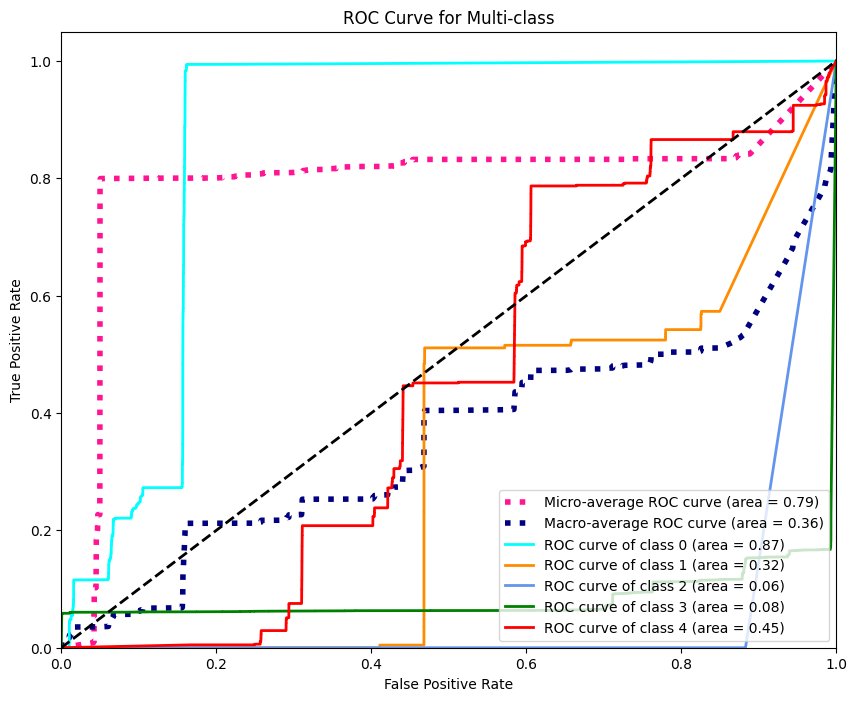

y_test_binarized shape: (98805, 5)
y_score shape: (98805, 5)


In [25]:
#load softmax regression model from softmaxregressionmodel.pkl
clf = joblib.load('softmaxregressionmodel.pkl')
y_test_binarized = label_binarize(Y_test_encoded, classes=np.unique(Y_test_encoded))
y_score = clf.predict_proba(X_test_selected)
roc_auc_macro = roc_auc_score(y_test_binarized, y_score, average='macro', multi_class='ovr')
roc_auc_micro = roc_auc_score(y_test_binarized, y_score, average='micro', multi_class='ovr')
print("ROC-AUC Score (Macro Average):", roc_auc_macro)
print("ROC-AUC Score (Micro Average):", roc_auc_micro)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC curve (area = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class')
plt.legend(loc="lower right")
plt.show()
print("y_test_binarized shape:", y_test_binarized.shape)
print("y_score shape:", y_score.shape)


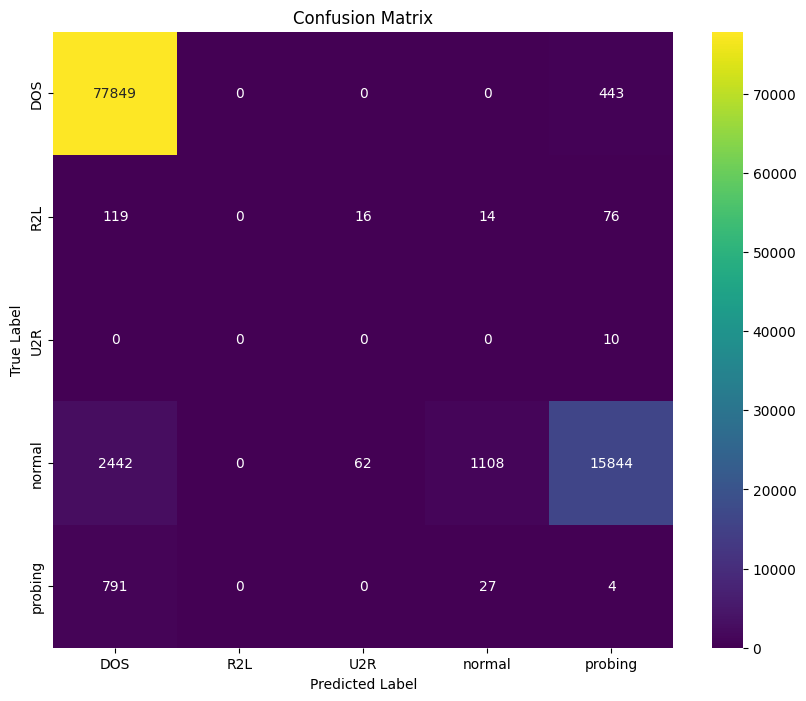

In [26]:
predictions = clf.predict(X_test_selected)
cm = confusion_matrix(Y_test_encoded, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2044
[LightGBM] [Info] Number of data points in the train set: 1563135, number of used features: 9
[LightGBM] [Info] Start training from score -1.608354
[LightGBM] [Info] Start training from score -1.610635
[LightGBM] [Info] Start training from score -1.608255
[LightGBM] [Info] Start training from score -1.611712
[LightGBM] [Info] Start training from score -1.608239
Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     78292
           1       0.00      0.00      0.00       225
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00     19456
           4       0.00      0.00      0.00       822

    accuracy                           0.79     98805
   macro avg       0.16      0.20    

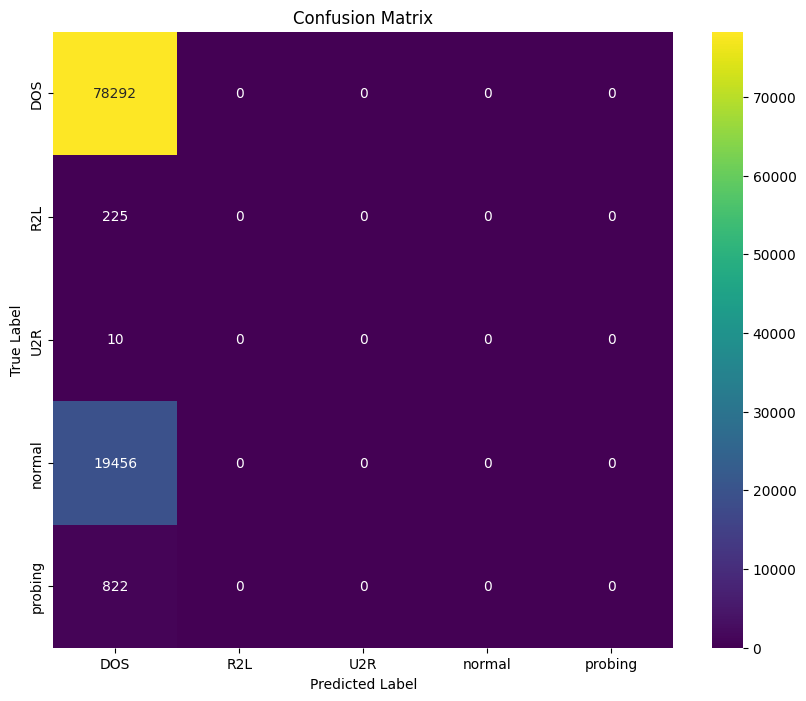

In [27]:
train_data = lgb.Dataset(X_train_selected, label=Y_train_resampled)
test_data = lgb.Dataset(X_test_selected, label=Y_test_encoded, reference=train_data)
params = {'objective': 'multiclass','boosting_type': 'gbdt','metric': 'multi_logloss','num_class': len(set(Y_train_resampled)),'learning_rate': 0.05,'num_leaves': 31,'feature_fraction': 0.9}
model = lgb.train(params, train_data, num_boost_round=100, valid_sets=[train_data, test_data])
predictions_proba = model.predict(X_test_selected, num_iteration=model.best_iteration)
predictions = [list(proba).index(max(proba)) for proba in predictions_proba]
print('Classification Report:')
print(classification_report(Y_test_encoded, predictions, zero_division=0))
accuracy = accuracy_score(Y_test_encoded, predictions)
print(f"Model Accuracy: {accuracy:.4f}")
joblib.dump(model, 'lightgbm_model.pkl')
print("Model saved as lightgbm_model.pkl.")
cm = confusion_matrix(Y_test_encoded, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

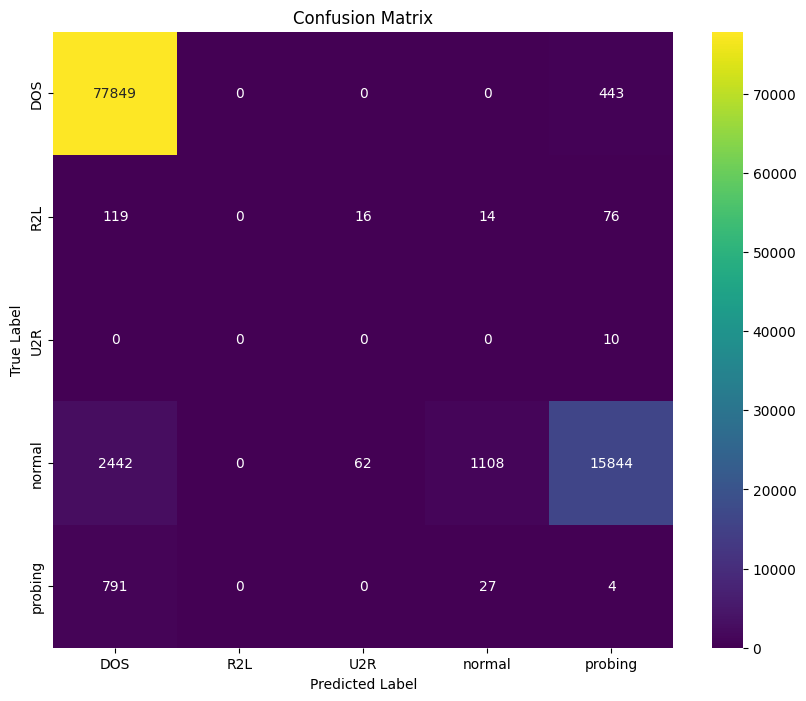

In [28]:
#plot confusion matrix for softmax regression model
from sklearn.metrics import confusion_matrix

predictions = clf.predict(X_test_selected)

# Compute confusion matrix
cm = confusion_matrix(Y_test_encoded, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

ENSEMBLE METHODS

Naive Bayes already trained. Loading from Naive_Bayes_model.pkl...
Performance for Naive Bayes:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     78292
           1       0.00      0.00      0.00       225
           2       0.00      0.00      0.00        10
           3       0.17      0.00      0.00     19456
           4       0.00      0.02      0.00       822

    accuracy                           0.79     98805
   macro avg       0.22      0.20      0.19     98805
weighted avg       0.78      0.79      0.77     98805

Naive Bayes Accuracy: 0.7881
--------------------------------------------------
K-NN already trained. Loading from K-NN_model.pkl...
Performance for K-NN:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     78292
           1       0.00      0.00      0.00       225
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00

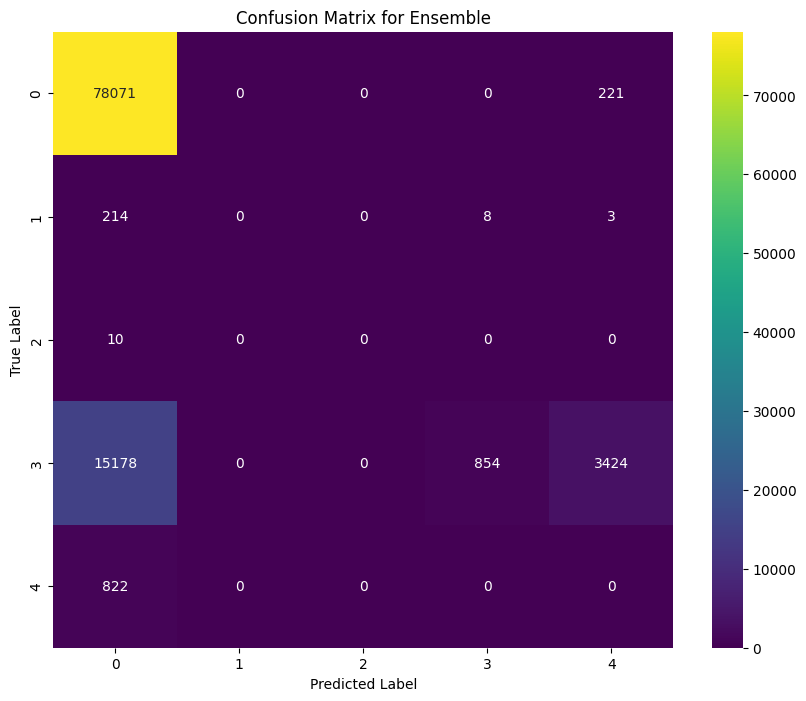

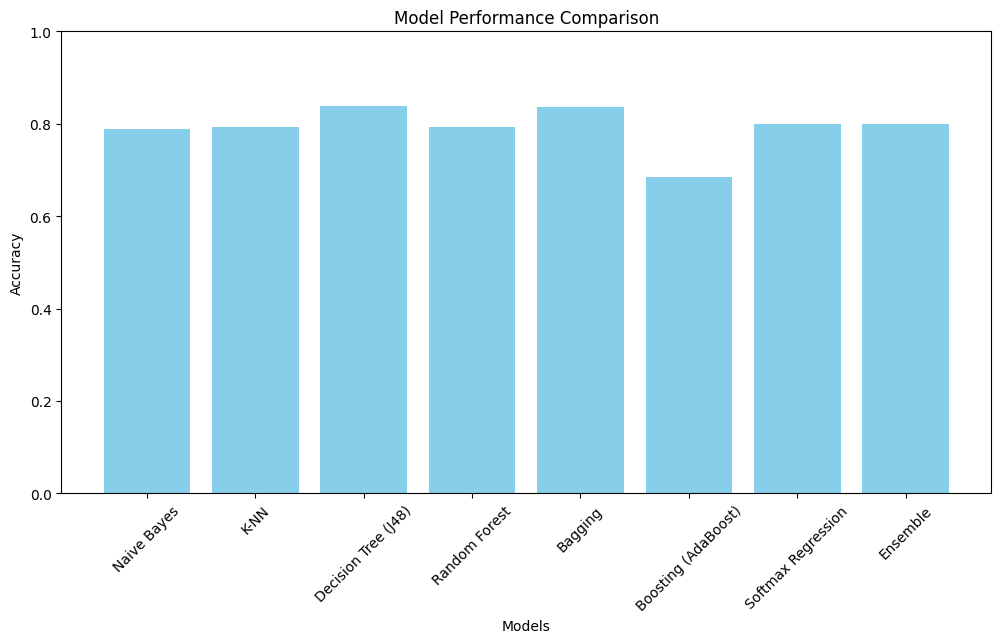

In [29]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

models = {
    "Naive Bayes": GaussianNB(),
    "K-NN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree (J48)": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    # "SVM (linear)": SVC(kernel='linear', probability=True),
    "Bagging": BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10),
    "Boosting (AdaBoost)": AdaBoostClassifier(),
    "Softmax Regression": LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
}

performance = {}
loaded_models = {}

for name, model in models.items():
    filename = f"{name.replace(' ', '_')}_model.pkl"
    if os.path.exists(filename):
        print(f"{name} already trained. Loading from {filename}...")
        loaded_models[name] = joblib.load(filename)
    else:
        print(f"Training {name}...")
        model.fit(X_train_selected, Y_train_resampled)
        joblib.dump(model, filename)
        print(f"Model saved as {filename}.")
        loaded_models[name] = model
    
    predictions = loaded_models[name].predict(X_test_selected)
    print(f"Performance for {name}:")
    print(classification_report(Y_test_encoded, predictions, zero_division=0))
    accuracy = accuracy_score(Y_test_encoded, predictions)
    performance[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")
    print('-' * 50)

ensemble_predictions = []
for i in range(len(X_test_selected)):
    votes = []
    for name, model in loaded_models.items():
        prediction = model.predict([X_test_selected.iloc[i]])[0]
        votes.append(prediction)
    ensemble_predictions.append(np.bincount(votes).argmax())

print("Performance for Ensemble Model (Majority Voting):")
print(classification_report(Y_test_encoded, ensemble_predictions, zero_division=0))
ensemble_accuracy = accuracy_score(Y_test_encoded, ensemble_predictions)
performance['Ensemble'] = ensemble_accuracy
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(Y_test_encoded, ensemble_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=np.unique(Y_test_encoded), yticklabels=np.unique(Y_test_encoded))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Ensemble')
plt.show()

# Performance Comparison
plt.figure(figsize=(12, 6))
plt.bar(performance.keys(), performance.values(), color='skyblue')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

ENSEMBLE METHODS WITH XGBOOST

Naive Bayes already trained. Loading from Naive_Bayes_model.pkl...
Performance for Naive Bayes:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     78292
           1       0.00      0.00      0.00       225
           2       0.00      0.00      0.00        10
           3       0.17      0.00      0.00     19456
           4       0.00      0.02      0.00       822

    accuracy                           0.79     98805
   macro avg       0.22      0.20      0.19     98805
weighted avg       0.78      0.79      0.77     98805

Naive Bayes Accuracy: 0.7881
--------------------------------------------------
K-NN already trained. Loading from K-NN_model.pkl...
Performance for K-NN:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     78292
           1       0.00      0.00      0.00       225
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00

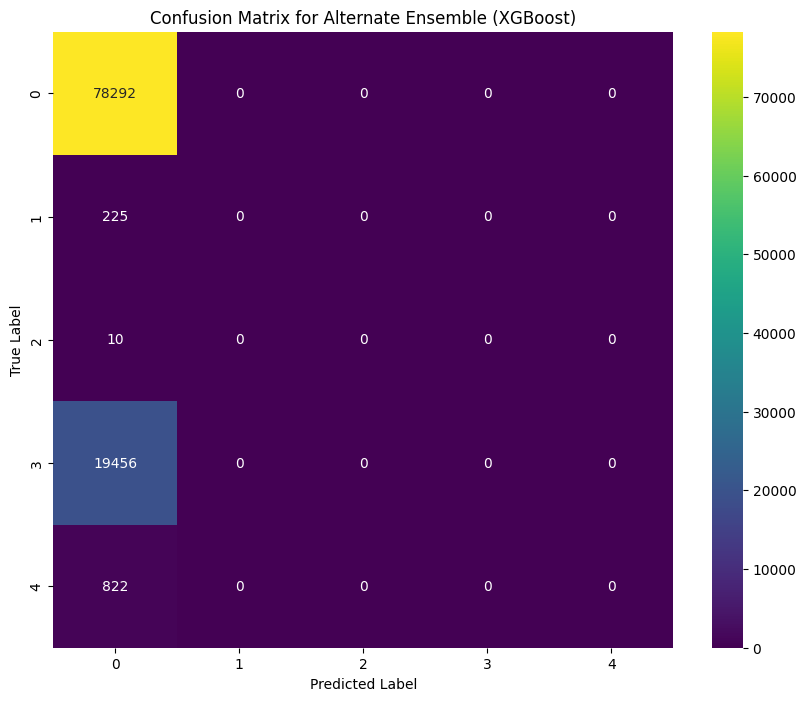

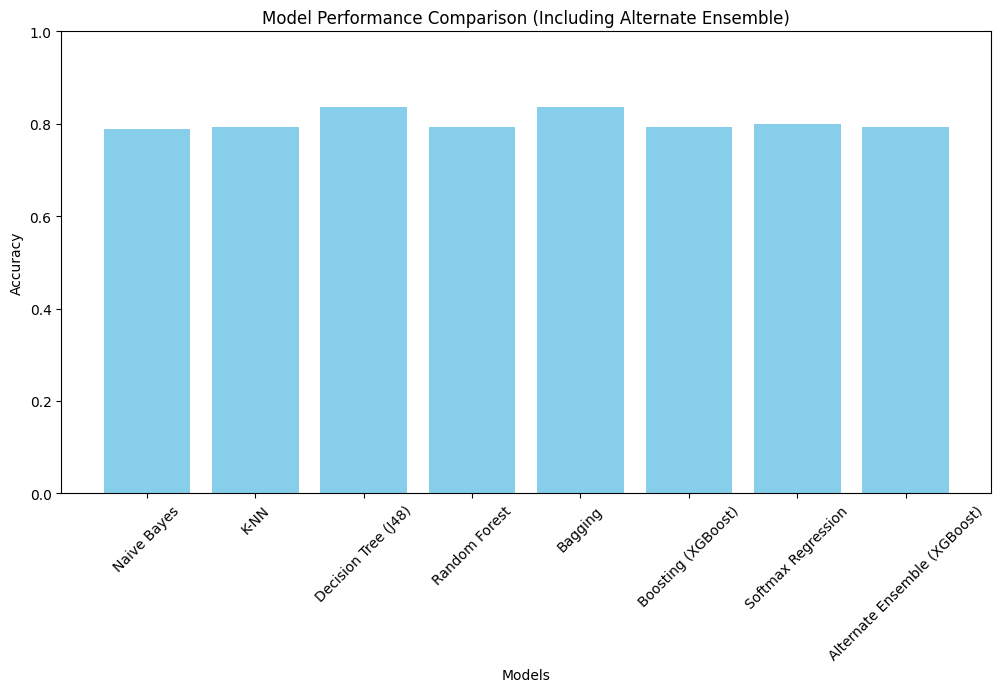

In [30]:
!pip install xgboost
from xgboost import XGBClassifier  # Import XGBoost classifier

# Add XGBoost to models
models = {
    "Naive Bayes": GaussianNB(),
    "K-NN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree (J48)": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    # "SVM (linear)": SVC(kernel='linear', probability=True),
    "Bagging": BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10),
    "Boosting (XGBoost)": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Softmax Regression": LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
}

performance = {}
loaded_models = {}

for name, model in models.items():
    filename = f"{name.replace(' ', '_')}_model.pkl"
    if os.path.exists(filename):
        print(f"{name} already trained. Loading from {filename}...")
        loaded_models[name] = joblib.load(filename)
    else:
        print(f"Training {name}...")
        model.fit(X_train_selected, Y_train_resampled)
        joblib.dump(model, filename)
        print(f"Model saved as {filename}.")
        loaded_models[name] = model
    
    predictions = loaded_models[name].predict(X_test_selected)
    print(f"Performance for {name}:")
    print(classification_report(Y_test_encoded, predictions, zero_division=0))
    accuracy = accuracy_score(Y_test_encoded, predictions)
    performance[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")
    print('-' * 50)

# Alternate Ensemble with XGBoost
ensemble_predictions_xgb = []
for i in range(len(X_test_selected)):
    votes = []
    for name, model in loaded_models.items():
        if name != "Boosting (AdaBoost)":
            prediction = model.predict([X_test_selected.iloc[i]])[0]
            votes.append(prediction)
    ensemble_predictions_xgb.append(np.bincount(votes).argmax())

print("Performance for Alternate Ensemble Model (Majority Voting with XGBoost):")
print(classification_report(Y_test_encoded, ensemble_predictions_xgb, zero_division=0))
ensemble_accuracy_xgb = accuracy_score(Y_test_encoded, ensemble_predictions_xgb)
performance['Alternate Ensemble (XGBoost)'] = ensemble_accuracy_xgb
print(f"Alternate Ensemble Accuracy: {ensemble_accuracy_xgb:.4f}")

# Confusion Matrix for Alternate Ensemble
cm_xgb = confusion_matrix(Y_test_encoded, ensemble_predictions_xgb)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='viridis', xticklabels=np.unique(Y_test_encoded), yticklabels=np.unique(Y_test_encoded))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Alternate Ensemble (XGBoost)')
plt.show()

# Performance Comparison
plt.figure(figsize=(12, 6))
plt.bar(performance.keys(), performance.values(), color='skyblue')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.title('Model Performance Comparison (Including Alternate Ensemble)')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

ANN(MLP)

In [31]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define the MLPClassifier (ANN) and parameter grid
mlp = MLPClassifier(random_state=42, max_iter=500)

param_grid = {
    'hidden_layer_sizes': [(128, 64)],#[(32,), (64,), (128,), (64, 32), (128, 64)],  # Vary number of neurons/layers
    'activation': ['tanh'],  # Activation functions to try
    'solver': ['adam'],#, 'sgd'],  # Optimizers
    'alpha': [0.001],#, 0.01],  # L2 regularization (weight decay)
    'learning_rate': ['constant'],#, 'adaptive'],  # Learning rate schedule
    'batch_size': [64],  # Batch size for mini-batch gradient descent
}

# Perform GridSearch with cross-validation
grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=None,  # 3-fold cross-validation
    scoring='accuracy',  # Use accuracy as the evaluation metric
    verbose=2,
    n_jobs=-1  # Utilize all CPU cores
)

# Fit the GridSearchCV with the training data
grid_search.fit(X_train_selected, Y_train_resampled)

# Evaluate the best model on test data
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_selected)

# Encode Test Labels
label_encoder = load_model_instance('label_encoder')
Y_test_encoded = label_encoder.fit_transform(Y_test)
Y_test_encoded = pd.Series(Y_test_encoded)

# Performance Evaluation
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)
print('Classification Report:')
print(classification_report(Y_test_encoded, predictions, zero_division=0))

accuracy = accuracy_score(Y_test_encoded, predictions)
print(f"Test Accuracy of Best Model: {accuracy:.4f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(128, 64), learning_rate=constant, solver=adam; total time=21.7min
[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(128, 64), learning_rate=constant, solver=adam; total time=26.9min
[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(128, 64), learning_rate=constant, solver=adam; total time=28.9min
[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(128, 64), learning_rate=constant, solver=adam; total time=28.9min
[CV] END activation=tanh, alpha=0.001, batch_size=64, hidden_layer_sizes=(128, 64), learning_rate=constant, solver=adam; total time=35.7min
Loading model instance: label_encoder...
Best Hyperparameters: {'activation': 'tanh', 'alpha': 0.001, 'batch_size': 64, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'constant', 'solver': 'adam'}
Best Cross-Validation Accuracy: 0.9762125472208096
Classification Report:
              precision   